In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from d2d import *



filename = "/data/fast0/datasets/Rhone_data_continuous.h5"
f = h5py.File(filename, 'r')
print("Keys: %s" % f.keys())

In [2]:
das_data_all = f['DAS Data'][:]
discharge = f['Discharge'][:]

df_all_chan = pd.DataFrame(das_data_all)
df_all_chan['Discharge'] = discharge
df_all_chan.head()

,0,1,2,3,4,5,6,7,8,9,...,2487,2488,2489,2490,2491,2492,2493,2494,2495,Discharge
0,1737.318436,1932.321258,1788.269101,3706.977556,1831.756626,1768.674227,1908.850695,3690.341997,1804.145150,2437.436803,...,3603.932847,2066.070800,2215.669390,1881.772352,3990.883595,1584.965970,1787.281257,1862.912440,4160.545583,9.947179
1,8161.349279,8245.783723,8118.189935,528.834231,468.890511,714.714310,728.051775,158.440806,82.719811,116.949415,...,8238.452283,8204.901437,8194.671705,8228.769841,8211.066134,8229.370787,8218.436955,8210.143402,8178.032001,9.934657
2,8242.942236,8205.640252,8093.980026,510.832905,451.884623,709.510655,709.932307,153.715844,83.404382,116.112236,...,8184.500407,8221.490571,8202.429647,8194.927561,8197.675324,8188.718827,8189.658071,8225.017259,8163.918322,9.929290
3,8159.780047,8196.654224,8113.873839,489.734947,438.657688,690.418208,701.896139,158.058233,83.003254,112.787627,...,8173.860868,8156.187127,8151.113841,8235.843141,8145.360321,8192.392266,8169.275389,8129.926491,8161.652382,9.923923
4,8198.498465,8161.470921,8120.452338,521.425978,444.272741,689.710217,695.164917,160.246640,84.054029,111.125592,...,8198.827286,8234.815465,8219.987333,8140.961605,8193.517740,8157.154485,8241.648596,8229.194191,8234.212679,9.918557


## Examine the linear model weights

5


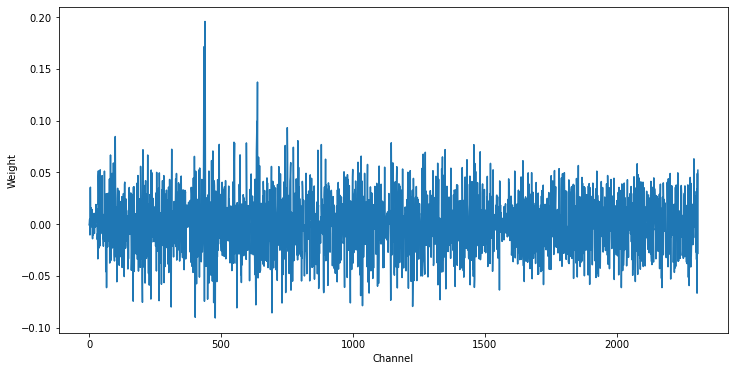

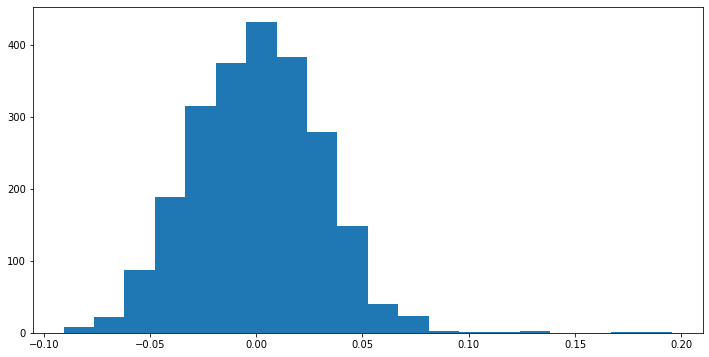

In [32]:
weights = linear.layers[0].kernel[:,0].numpy()

plt.subplots(figsize=(12,6))
plt.plot(weights)
plt.xlabel('Channel')
plt.ylabel('Weight')

plt.subplots(figsize=(12,6))
plt.hist(weights,20)
# plt.yscale('log')

print(np.sum(weights>0.1))

# Multistep Model Runs

# Retraining same model on different partitions of training, val, and test

### Can I create a for loop to do this?

In [6]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import os

linear_model = tf.keras.models.load_model(os.path.join("./saved_models/","linear_model_h5.h5"))
lstm_model = tf.keras.models.load_model(os.path.join("./saved_models/","lstm_model_h5.h5"))
dnn_model = tf.keras.models.load_model(os.path.join("./saved_models/","dnn_model_h5.h5"))

KeyboardInterrupt: 

<Figure size 432x1008 with 0 Axes>

{'Multistep_Linear_fold1_loss': [0.2469482421875, 0.1284521222114563, 0.1327584981918335], 'Multistep_Linear_fold1_val_loss': [0.46358636021614075, 0.3980445861816406, 0.4501346945762634], 'DNN_fold1_loss': [0.07536131888628006, 0.0269432682543993, 0.024700790643692017], 'DNN_fold1_val_loss': [0.591347336769104, 0.3530156910419464, 0.3357813060283661], 'LSTM_fold1_loss': [0.04532399773597717, 0.01811307482421398, 0.009123037569224834], 'LSTM_fold1_val_loss': [0.3099527359008789, 0.430936723947525, 0.4823187291622162]}


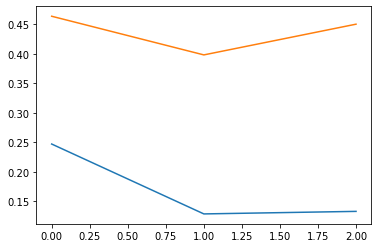

In [10]:
import pickle
import matplotlib.pyplot as plt
losses = pickle.load( open( "history_losses/history_losses_02_11_2021_13_22.pkl", "rb" ) )
print(losses)
plt.plot(losses['Multistep_Linear_fold1_loss'])
plt.plot(losses['Multistep_Linear_fold1_val_loss'])
plt.show()


{'Multistep_Linear_fold1_loss': [0.2278120517730713, 0.16685406863689423, 0.1234394982457161, 0.1318335235118866, 0.11953867971897125, 0.12336656451225281], 'Multistep_Linear_fold1_val_loss': [0.38409680128097534, 0.39810124039649963, 0.41780343651771545, 0.42609962821006775, 0.4293370842933655, 0.436428040266037], 'DNN_fold1_loss': [0.08489654213190079, 0.030390596017241478, 0.024230508133769035, 0.023285046219825745, 0.028546983376145363, 0.018723640590906143, 0.018281729891896248], 'DNN_fold1_val_loss': [0.8534664511680603, 0.3116821348667145, 0.3593555986881256, 0.4053140878677368, 0.3587803542613983, 0.3600284159183502, 0.3801543414592743], 'LSTM_fold1_loss': [0.053826771676540375, 0.011042137630283833, 0.009954054839909077, 0.010737153701484203, 0.0070285373367369175, 0.00755224609747529, 0.0054855914786458015], 'LSTM_fold1_val_loss': [0.24946101009845734, 0.22881928086280823, 0.310914546251297, 0.30868950486183167, 0.4170810282230377, 0.3789072632789612, 0.3308620750904083], 'Mu

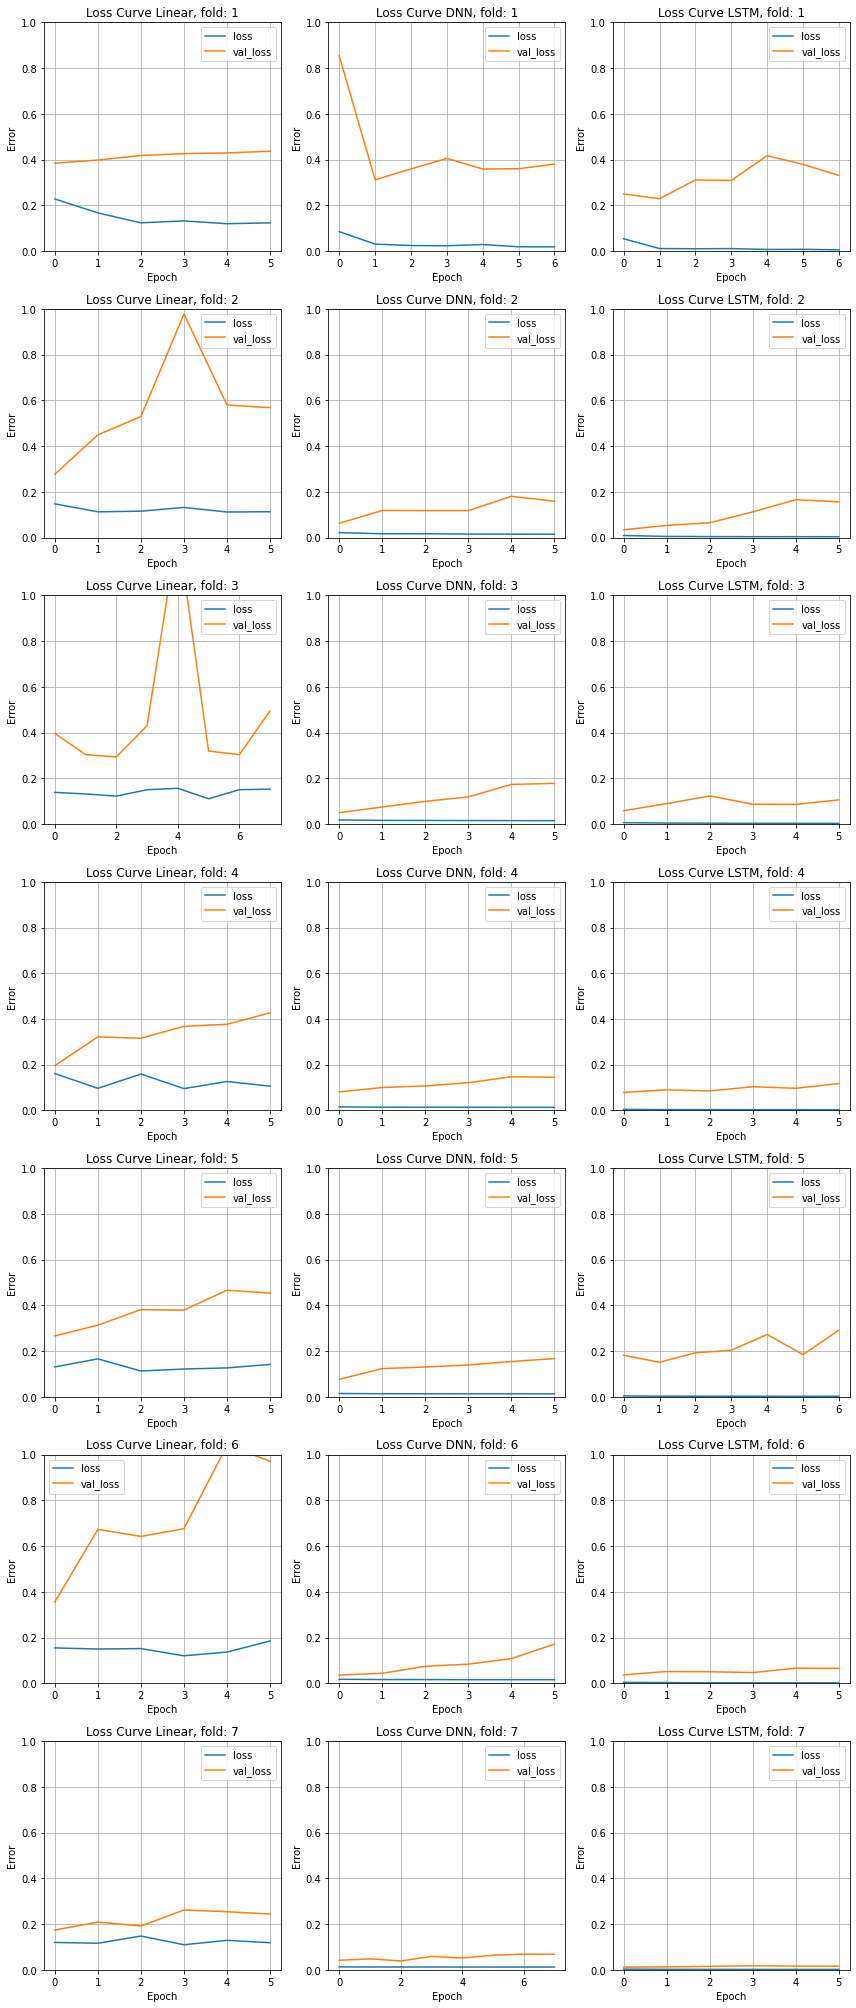

In [26]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

losses = pickle.load( open( "history_losses/history_losses_02_11_2021_20_11.pkl", "rb" ) )

now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M")

fig = plt.figure(figsize=(12, 28), facecolor='w', edgecolor='k')
a = 1


for k in range(1,8):

    #Linear model
    
    plt.subplot(7, 3, a)
    plt.clf
    plt.plot(losses['Multistep_Linear_fold'+str(k)+'_loss'], label='loss')
    plt.plot(losses['Multistep_Linear_fold'+str(k)+'_val_loss'], label='val_loss')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.title("Loss Curve Linear, fold: "+str(k))
    a += 1
    
    #DNN model
    
    plt.subplot(7, 3, a)
    plt.clf
    plt.plot(losses['DNN_fold'+str(k)+'_loss'], label='loss')
    plt.plot(losses['DNN_fold'+str(k)+'_val_loss'], label='val_loss')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.title("Loss Curve DNN, fold: "+str(k))
    a += 1
                
    #LSTM model
    
    plt.subplot(7, 3, a)
    plt.clf
    plt.plot(losses['LSTM_fold'+str(k)+'_loss'], label='loss')
    plt.plot(losses['LSTM_fold'+str(k)+'_val_loss'], label='val_loss')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.title("Loss Curve LSTM, fold: "+str(k))
    a += 1
    
    k+=1
    
    if k == 8: break
plt.tight_layout()
plt.savefig("loss_curves/loss_curves_02_11_2021_20_11.png", dpi=300, bbox_inches='tight')